# Dialogue Summarization with Hugging Face

## Introduction

In today's fast-paced world, extracting key information from conversations quickly and accurately is crucial. Whether it's customer service interactions, meeting transcripts, or chat logs, summarizing dialogues can save time and improve productivity.

## Objective

This project aims to develop a tool that automatically summarizes dialogues using Hugging Face's advanced NLP models. Our goal is to create concise and coherent summaries that capture the essence of the conversations.

In [33]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '20'

from datasets import load_dataset, Dataset
import matplotlib.pyplot as plt
import pandas as pd

### Loading and Displaying Samples from `samsum` and `dialogsum` Datasets

To work with the `samsum` and `dialogsum` datasets, we can use the Hugging Face `datasets` library. This library provides an easy way to load and preprocess datasets. Below, we'll show how to load these datasets and display a few samples from the `samsum` dataset.

In [4]:
samsum_dataset = load_dataset("knkarthick/samsum")
dialogsum_dataset = load_dataset("knkarthick/dialogsum")

samsum_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
})

In [5]:
dialogsum_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})

#### Display Samples

We define a function `show_samples` that will shuffle the dataset and select a specified number of samples to display. The function prints the dialogue and its corresponding summary for each sample.


In [6]:
def show_samples(dataset, num_samples=3, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'>> dialogue: {example['dialogue']}'")
        print(f"'>> summary: {example['summary']}'")


show_samples(samsum_dataset)


'>> dialogue: Lucy: omg did you see JK this morning?
Sue: I try to avoid it lol
Lucy: you should have seen it it was disgusting
Sue: I cant do it anymore i try to listen to the radio in the mornings.. jk makes you think the whole world is full of idiots lol
Lucy: you may be right I dont know how some of them can go on there in public for the world to see
Sue: I would die if I got a call to go on there lol
Sue: could you imagine ha ha 
Lucy: I would piss myself If I saw you and Andy up there
Sue: over my dead body !'
'>> summary: Sue doesn't watch JK any more as it's disgusting.'

'>> dialogue: Wendy: What's up?
Simon: Nothing much. I'm painting my cupboards. 
Angela: Cool what colour?
Simon: Green.
Ben: I'm just chilling in the garden. 
Angela: Nice weekend! I'm about to meet Chris.
Wendy: Say hello from me!
Angela: Will do! And how is your weekend, Wendy?
Wendy: Very lazy... The week was hard at work, I really needed some rest. 
Ben: We should all come and visit Simon in his new apar

### Cleaning Datasets

#### Define the `clean_dataset` function
This function filters out entries with summaries that are too short, or where either the summary or dialogue is `None`.

In [7]:
def clean_dataset(dataset):
    dataset = dataset.filter(lambda x: len(x["summary"].split()) > 2)
    dataset = dataset.filter(lambda x: x["summary"] is not None)
    dataset = dataset.filter(lambda x: x["dialogue"] is not None)
    return dataset

In [8]:
samsum_dataset = clean_dataset(samsum_dataset)
dialogsum_dataset = clean_dataset(dialogsum_dataset)

#### Merging Datasets

Use the `concatenate_datasets` function to merge the cleaned datasets and store them in a new `DatasetDict` called `english_dataset`.

In [9]:
from datasets import concatenate_datasets, DatasetDict

english_dataset = DatasetDict()

for split in samsum_dataset.keys():
    english_dataset[split] = concatenate_datasets(
        [samsum_dataset[split], dialogsum_dataset[split]]
    )
    english_dataset[split] = english_dataset[split].shuffle(seed=42)

# Peek at a few examples
show_samples(english_dataset)


'>> dialogue: #Person1#: So Peter, do you have a favorite comedy?
#Person2#: Well, that's hard to say because there are so many good ones. I don't think I could pick a favorite.
#Person1#: You know what comedy I really like? ' Ace Ventura, Pet Detective. ' I think Jim Carry is really funny.
#Person2#: Oh yeah, that's one of my favorite flicks. I think Jim Carry is one of the funniest comedians ever.
#Person1#: I agree. But even though I like comedies, I usually prefer more serious films. My favorite movie is ' Titanic. ''
'>> summary: Peter and #Person1# talk about their favourite comedies. They both like the comedian Jim Carry.'

'>> dialogue: Hal: Xmas is coming
Daphne: and ...
Hal: and I'd like to know what you would like to get this year
Daphne: surely not the Chinese crap you gave me last year
Hal: thought it was funny
Daphne: ridiculous rather. give me three days to think ok?
Hal: OK, otherwise I'll have to come up with sth and u know I'm not that good at it
Daphne: you bet'
'>>

### Visualizing the Dataset

In [10]:
english_dataset.set_format("pandas")
train_df = english_dataset["train"][:]
train_df

,id,dialogue,summary,topic
0,train_3045,#Person1#: Now I know why I split up with Mike...,#Person1# thinks she broke up with Mike becaus...,astrology and fact
1,13821145,"Tommy: dudes, I have an idea for a larp.\nAidy...",Tommy has an idea for a new larp. It's about w...,None
2,13731110,"George: Hey, let me know when you can make it ...",George and Alex are going to meet on Tuesday a...,None
3,13810213,Sophie: Hi my dear. A very happy birthday to y...,Sophie is wishing Mel a happy birthday. Mel is...,None
4,train_4656,"#Person1#: Bill, do you know when did the Chin...",#Person1# and Bill are talking about Teachers'...,Teachers' Day
...,...,...,...,...
27182,13729504,Pete: I wonder how Brexit will affect the situ...,Pete and Jake are worried about Brexit and Pol...,None
27183,13728042,Adam: need a drink\nAdam: wanna go to Paddys?\...,Adam and Will are going to Paddys at 7.,None
27184,13681133,Matthew: How was your trip to Italy?\nKim: It ...,Kim has been to Sicily in Italy. She visited t...,None
27185,train_7386,"#Person1#: Excuse me, sir, can you help me? I ...",#Person1# needs to buy a bed that isn't too bi...,buy a bed


### Analyzing Dialogues and Summary Lengths

This analysis helps in understanding the distribution and range of word lengths in both dialogues and summaries, which is essential for tasks such as text summarization, where optimal summary length is a consideration.

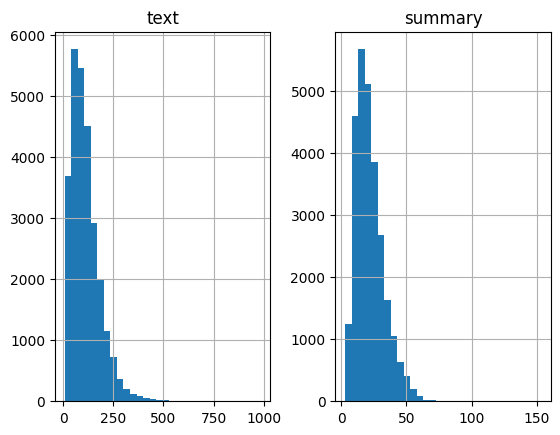

In [13]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in train_df['dialogue']:
      text_word_count.append(len(i.split()))

for i in train_df['summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

**From the plot analysis:**

- **Input Length (`max_input_length`)**: Dialogues typically peak around 350 words, suggesting `max_input_length = 350` captures the majority of dialogues adequately without significant truncation.

- **Target Length (`max_target_length`)**: Summaries tend to center around 50 words, making `max_target_length = 50` suitable for generating concise and informative summaries aligned with the original dialogues.


In [14]:
max_input_length = 350
max_target_length = 50

### Removing Columns from `english_dataset`

The code snippet below removes the 'id' and 'topic' columns from `english_dataset`:

In [17]:
english_dataset = english_dataset.remove_columns(['id'])
english_dataset = english_dataset.remove_columns(['topic'])

english_dataset

DatasetDict({
    train: Dataset({
        features: ['dialogue', 'summary'],
        num_rows: 27187
    })
    validation: Dataset({
        features: ['dialogue', 'summary'],
        num_rows: 1318
    })
    test: Dataset({
        features: ['dialogue', 'summary'],
        num_rows: 2319
    })
})

### Tokenizing Text Data with Transformers

  - Here, `"t5-small"` is chosen as the model checkpoint, indicating a smaller version of the T5 model.
  - The `AutoTokenizer.from_pretrained` method loads and caches the tokenizer associated with the specified model checkpoint.
  - This tokenizer can then be used to convert text into a format suitable for training.


In [2]:
from transformers import AutoTokenizer

model_checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [3]:
inputs = tokenizer("I loved learning about Machine Learning!")
inputs

{'input_ids': [27, 1858, 1036, 81, 5879, 6630, 55, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [4]:
tokenizer.convert_ids_to_tokens(inputs.input_ids)

['▁I', '▁loved', '▁learning', '▁about', '▁Machine', '▁Learning', '!', '</s>']

### Text Preprocessing with Tokenization

This code snippet demonstrates text preprocessing using a tokenizer:

1. **Dataset Formatting**:
   It resets `english_dataset` to its original format.

2. **Preprocessing Function**:
   - **Purpose**: Tokenizes dialogues and summaries with `tokenizer`, ensuring sequences adhere to specified maximum lengths (`max_input_length` for dialogues and `max_target_length` for summaries).
   - **Key Step**: `model_inputs["labels"] = labels["input_ids"]` prepares data for sequence-to-sequence models, crucial for tasks like text summarization.

### Sequence-to-Sequence Models

In sequence-to-sequence models:

- **Input Sequence**: Text input (e.g., dialogue).
- **Output Sequence**: Text to generate (e.g., summary).

### Tokenization

Using a `tokenizer`, text converts to token IDs:

1. **Dialogue Tokenization**: Converts dialogue to tokens in `model_inputs`.
2. **Summary Tokenization**: Converts summary to tokens in `labels`.

### Model Inputs and Labels

- **Model Inputs**: Tokenized dialogue for model input.
- **Labels**: Tokenized summary for model target during training.

This preprocesses text for models, enhancing training and prediction accuracy.

In [18]:
english_dataset.reset_format()

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["dialogue"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["summary"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs
    
# Apply the preprocessing function to the dataset
tokenized_datasets = english_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1318 [00:00<?, ? examples/s]

### Baseline Summary Generation

The `three_sentence_summary` function utilizes NLTK's `sent_tokenize` to extract the initial three sentences from a text, establishing a basic baseline for summarization. This method ensures accurate segmentation, accommodating complex cases like acronyms ("U.S.", "U.N.").

This approach is foundational in summarization tasks, offering a straightforward yet effective method to condense text into a concise summary.

In [19]:
import nltk

nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/negar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
from nltk.tokenize import sent_tokenize


def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])


print(three_sentence_summary(english_dataset['train'][1]["dialogue"]))

Tommy: dudes, I have an idea for a larp.
Aidy: go on
Connor: let's hear it.
Tommy: It would be about witches a'la new Sabrina, a coven meeting, modern style, but with a victorian twist
Sarah: sounds cute
Tommy: you wanna know the twist?


### Evaluating Summarization with ROUGE Score

#### ROUGE Score

The ROUGE (Recall-Oriented Understudy for Gisting Evaluation) score is a metric commonly used to assess the quality of text summarization. It measures the overlap and similarity between a generated summary and one or more reference summaries.

   - **Purpose**: The `evaluate_baseline` function generates summaries (`summaries`) using `three_sentence_summary` for each dialogue in `dataset["dialogue"]`. It then computes the ROUGE score (`metric.compute`) by comparing these generated summaries (`predictions`) against human-written reference summaries (`references`).


In [22]:
# pip install rouge_score
# pip install evaluate

In [23]:
import evaluate

rouge_score = evaluate.load("rouge")

In [21]:
def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(text) for text in dataset["dialogue"]]
    return metric.compute(predictions=summaries, references=dataset["summary"])

In [25]:
score = evaluate_baseline(english_dataset["validation"], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn] * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 28.69, 'rouge2': 8.54, 'rougeL': 22.56, 'rougeLsum': 25.86}

### Fine-tuning T5 with the Trainer API

1. **Loading the Pretrained Model**:

   - **Model Initialization**: Loads the pre-trained T5 model from the `t5-small` checkpoint using `AutoModelForSeq2SeqLM`. This class is designed for sequence-to-sequence tasks, such as summarization, and will automatically download and cache the model weights.

2. **Data Collation for Training**:
   - **Purpose**: For encoder-decoder models like T5, it's important to shift the labels to the right by one during decoding. This ensures the decoder only sees the previous ground truth labels, preventing it from memorizing current or future labels.
   - **Solution**: The `DataCollatorForSeq2Seq` dynamically pads inputs and labels, handling the label shifting automatically.
   - **Data Collator**: Prepares the data collator to handle tokenization, padding, and batching for training. This ensures that inputs and labels are correctly formatted for the model.

These steps set up the model and data pipeline for fine-tuning T5 on summarization tasks. Using the `Trainer` API simplifies the training process by managing the training loop, evaluation, and other necessary tasks.

In [25]:
from transformers import TFAutoModelForSeq2SeqLM

model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [26]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

3. **Removing String Columns**:
   - **Reason**: Removes columns with string data from the tokenized datasets. This step ensures that the data collator only processes columns it can pad, such as token IDs, attention masks, and labels.

In [27]:
tokenized_datasets = tokenized_datasets.remove_columns(
    english_dataset["train"].column_names
)

In [28]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 27187
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1318
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2319
    })
})

4. **Formatting Data for the Data Collator**:
   - **Reason**: The data collator expects a list of dictionaries, each representing a single example in the dataset. We need to format the data into this expected structure before passing it to the data collator.

   - **Data Wrangling**: Prepares a list of examples (`features`) from the tokenized training dataset and passes it to the data collator. This ensures the data is correctly padded and ready for model training.
  
3. **Observing Data Collation Effects**:
   - **Padding**: The first example might be longer than the second, so the `input_ids` and `attention_mask` of the second example are padded on the right with a `[PAD]` token (ID 0).
   - **Labels Padding**: Labels are padded with `-100` to ensure that padding tokens are ignored by the loss function.
   - **Decoder Input IDs**: A new `decoder_input_ids` is created by shifting the labels to the right, inserting a `[PAD]` token at the first entry.

In [29]:
features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

{'input_ids': <tf.Tensor: shape=(2, 350), dtype=int32, numpy=
array([[ 1713,   345, 13515,   536,  4663,    10,   852,    27,   214,
          572,    27,  5679,    95,    28,  4794,     5,   101,   435,
           62,   130,   914,    59,   207,    21,   284,   119,     5,
         1713,   345, 13515,   357,  4663,    10,    86,   125,  1155,
           58,  1713,   345, 13515,   536,  4663,    10,  1548,     6,
            3,    88,    19,     3,     9,  4541,   180,  5356,  5310,
          302,  4024,     6,   298,    27,   183,     3,     9,  9520,
            5,   101,    33,    29,    31,    17,   310,  7441,  1713,
          345, 13515,   357,  4663,    10,  1626,    18,  1024,     6,
           78,    25,   857,    16,     3, 12163,  1863,    58,  1713,
          345, 13515,   536,  4663,    10,   363,    31,     7,  6765,
           81,    24,    55,   282,     3,     9,   568,  2170,   365,
            8,  1320,    13,  9520,     6,    27,   183,   234,    18,
         5850, 

### Converting Datasets

**Convert Training and Evaluation Datasets**:
   - **Training Dataset**: The training dataset is prepared using `model.prepare_tf_dataset`, with shuffling enabled and a batch size of 8. This ensures that the training data is fed into the model in a randomized order, which helps improve generalization.
   - **Evaluation Dataset**: The evaluation dataset is similarly prepared but without shuffling, ensuring that the evaluation data is fed in a consistent order for accurate assessment of model performance.


In [32]:
tf_train_dataset = model.prepare_tf_dataset(
    tokenized_datasets["train"],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=16,
)
tf_eval_dataset = model.prepare_tf_dataset(
    tokenized_datasets["validation"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=16,
)
# Example of iterating over batches
for batch in tf_train_dataset.take(1):
    print(batch)

({'input_ids': <tf.Tensor: shape=(16, 350), dtype=int64, numpy=
array([[ 1713,   345, 13515, ...,     0,     0,     0],
       [ 1713,   345, 13515, ...,     0,     0,     0],
       [ 1022,     7,  2452, ...,     0,     0,     0],
       ...,
       [ 1713,   345, 13515, ...,  1807,    11,     1],
       [21412,    10,     3, ...,     0,     0,     0],
       [ 1713,   345, 13515, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(16, 350), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>, 'decoder_input_ids': <tf.Tensor: shape=(16, 50), dtype=int64, numpy=
array([[    0,  1079,    19, 12744,   250,     3,    88,    19,    29,
           31,    17,  2918,    11,   744,    31,    17,   129,   590,
          168,    28,   119,  1652,     5,  1713,   345, 13515,   357,
         4663,   987,     7, 

### Fine-tuning T5

We are now ready to set up the optimizer, compile the model, and enable mixed-precision training. Here’s how to proceed:

1. **Setting Up the Optimizer**:

   - **Number of Training Steps**: Calculate the total number of training steps based on the dataset size, batch size, and number of epochs.
   - **Optimizer**: Create an optimizer with a specified initial learning rate, no warmup steps, and a weight decay rate.
   - **Compile Model**: Compile the model with the created optimizer.



2. **Enable Mixed-Precision Training**:
   - **Mixed-Precision Training**: Set the global policy to "mixed_float16" to enable mixed-precision training, which can improve performance and reduce memory usage by utilizing 16-bit floating-point precision where possible.


In [35]:
from transformers import create_optimizer
import tensorflow as tf

# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_epochs = 10
num_train_steps = len(tf_train_dataset) * num_train_epochs
model_name = model_checkpoint.split("/")[-1]

optimizer, schedule = create_optimizer(
    init_lr=5.6e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

model.compile(optimizer=optimizer)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [36]:
model.fit(
    tf_train_dataset, validation_data=tf_eval_dataset ,verbose=True, epochs=10
)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x7f2094713f10>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1699/1699 [==============================] - 551s 287ms/step - loss: 1.8564 - val_loss: 1.6245
Epoch 2/10
1699/1699 [==============================] - 469s 276ms/step - loss: 1.6880 - val_loss: 1.5648
Epoch 3/10
1699/1699 [==============================] - 471s 277ms/step - loss: 1.6243 - val_loss: 1.5383
Epoch 4/10
1699/1699 [==============================] - 471s 277ms/step - loss: 1.5838 - val_loss: 1.5170
Epoch 5/10
1699/1699 [==============================] - 471s 277ms/step - loss: 1.5507 - val_loss: 1.5007
Epoch 6/10
1699/1699 [==============================] - 470s 277ms/step - loss: 1.5261 - val_loss: 1.4952
Epoch 7/10
1699/1699 [==============================] - 470s 

## Saving and loading the Model

In [ ]:
model.save_pretrained("t5small") 

In [2]:
from transformers import TFAutoModelForSeq2SeqLM

model = TFAutoModelForSeq2SeqLM.from_pretrained("model/t5small")

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at model/t5small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


### Generating Outputs and Evaluating ROUGE Metrics

After training our model, we want to evaluate its performance using ROUGE metrics. To do this, we'll generate outputs from the model and convert them to strings for comparison. We can optimize this process using TensorFlow’s XLA (Accelerated Linear Algebra) compiler for improved speed and memory usage.

Here's how to set up and use XLA for generating predictions:

1. **Setting Up Data Collator and Dataset**:
   - **Data Collator**: Pad inputs to multiples of 320 for consistent input shapes, which is beneficial for XLA optimization.
   - **Dataset Preparation**: Prepare the validation dataset with the generation data collator.

2. **Generating Outputs with XLA**:
   - **XLA Compilation**: Apply the `@tf.function(jit_compile=True)` decorator to mark the generation function for XLA compilation.

3. **Collecting Predictions and Labels**:
   - **Loop through Dataset**: Generate predictions for each batch, decode the predictions and labels, and store them for ROUGE evaluation.

In [34]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf

generation_data_collator = DataCollatorForSeq2Seq(
    tokenizer, model=model, return_tensors="tf", pad_to_multiple_of=320
)

tf_generate_dataset = model.prepare_tf_dataset(
    tokenized_datasets["test"],
    collate_fn=generation_data_collator,
    shuffle=False,
    batch_size=8,
    drop_remainder=True,
)


@tf.function(jit_compile=True)
def generate_with_xla(batch):
    return model.generate(
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"],
        max_new_tokens=32,
    )


all_preds = []
all_labels = []
for batch, labels in tqdm(tf_generate_dataset):
    predictions = generate_with_xla(batch)
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = labels.numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    all_preds.extend(decoded_preds)
    all_labels.extend(decoded_labels)

  0%|                                                   | 0/289 [00:00<?, ?it/s]W0000 00:00:1721168721.853366  177292 assert_op.cc:38] Ignoring Assert operator encoder/assert_less/Assert/Assert
W0000 00:00:1721168721.933658  177292 assert_op.cc:38] Ignoring Assert operator tft5_for_conditional_generation_1/decoder/assert_less/Assert/Assert
W0000 00:00:1721168722.110381  177292 assert_op.cc:38] Ignoring Assert operator while/tft5_for_conditional_generation_1/decoder/assert_less/Assert/Assert
  0%|▏                                          | 1/289 [00:04<21:11,  4.41s/it]W0000 00:00:1721168726.400773  177292 assert_op.cc:38] Ignoring Assert operator encoder/assert_less/Assert/Assert
W0000 00:00:1721168726.494179  177292 assert_op.cc:38] Ignoring Assert operator tft5_for_conditional_generation_1/decoder/assert_less/Assert/Assert
W0000 00:00:1721168726.687617  177292 assert_op.cc:38] Ignoring Assert operator while/tft5_for_conditional_generation_1/decoder/assert_less/Assert/Assert
100%|███

### Evaluate

In [35]:
result = rouge_score.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True
)
result = {key: value * 100 for key, value in result.items()}
{k: round(v, 4) for k, v in result.items()}

{'rouge1': 42.7166, 'rouge2': 15.7808, 'rougeL': 33.6738, 'rougeLsum': 37.8919}

### Using Fine-tuned Model

Once we've fine-tuned the model, we can use it for inference. 

- **Pipeline Object**: The `pipeline` function simplifies the process of using the model for a specific task, such as summarization. By specifying `"summarization"` and providing the fine-tuned model, you create an easy-to-use summarizer.
- **Inference**: The `summarizer` can then be used to generate summaries for any input text, making it convenient to leverage the fine-tuned model for real-world applications.


In [36]:
from transformers import pipeline
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)

In [37]:
def print_summary(idx):
    review = english_dataset["test"][idx]["dialogue"]
    title = english_dataset["test"][idx]["summary"]
    summary = summarizer(english_dataset["test"][idx]["dialogue"])[0]["summary_text"]
    print(f"'>>> Review: {review}'")
    print(f"\n'>>> Title: {title}'")
    print(f"\n'>>> Summary: {summary}'")

In [42]:
print_summary(100)

Your max_length is set to 200, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


'>>> Review: Josh: Stephen, I think you've accidentaly taken my notebook home
Stephen: wait lemme check
Stephen: nope, I don't see it anywhere
Jack: oh shit, I've got it xDDD I don't even know why
Josh: xDDD ok, no problem, cool I know where it is
Jack: I'll bring it tomorow'

'>>> Title: Josh thinks Stephen accidentally took his notebook. Jack has it and will bring it tomorrow.'

'>>> Summary: Stephen accidentally took his notebook home. Jack will bring it tomorow, but he doesn't know where it's and he's not sure why.'


### Make predictions

In [47]:
dialogue = """
Detective Miller: "Mr. Evans, do you know why you're here?"

Tom Evans: "I already told you, I don't know anything about the robbery. I was at home."

Detective Miller: "A witness saw you near the jewelry store that night."

Tom Evans: "That's impossible! I was home."

Detective Miller: (showing a photo) "This blurry image matches your tattoo."

Tom Evans: "Fine, I was there. But I didn’t do anything. I was just watching."

Detective Miller: "Watching? You need to tell the full story."

Tom Evans: "Alright, but I need protection. Those guys don’t play around."

Detective Miller: "You help us, we help you. Start talking."

Tom Evans: "Okay... it started a few weeks ago..."
"""

summarizer(dialogue)[0]["summary_text"]

Your max_length is set to 200, but your input_length is only 186. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


"a witness saw Tom Evans near the jewelry store that night. Detective Miller helps him to tell the full story, but he doesn't know what to do."